# Reducing QAOA Circuit Depth by Factoring out Semi-Symmetries

## References
1. https://arxiv.org/abs/2411.08824
2. https://arxiv.org/abs/2412.17841

In [1]:
import numpy as np
from docplex.mp.model import Model
from docplex.mp.model_reader import ModelReader
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import networkx as nx

## Load Moderna instance

In [2]:
path = "seq_1314_c.lp"
mod = Model()
mod = ModelReader.read_model(path)

#convert linear program to qubo
qp = from_docplex_mp(mod)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
cost_operator, offset = qubo.to_ising()

# convert QP to a upper triangular QUBO matrix
Q = qubo.objective.quadratic.to_array(symmetric=False)
Q += np.identity(Q.shape[0])*qubo.objective.linear.to_array()
print(Q.shape)
#print(qubo.export_as_lp_string())

(50, 50)


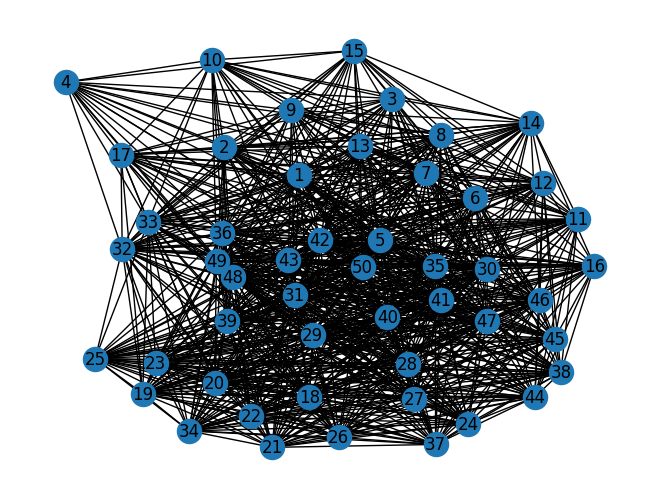

In [3]:
N, M = Q.shape
edges = []
for i in range(N):
    for j in range(i+1, M):
        if Q[i, j] > 0:
            edges.append((i+1, j+1))
G = nx.Graph(edges)
np.random.seed(0)
nx.draw(G, with_labels=True)

## Modules for factoring out semi-symmetries

Modules used in "Algorithm 1 Factoring out Semi-Symmetries":

In [4]:
def get_conflict_list(Q):
    cL = []
    n = Q.shape[0]
    Z = [sum([Q[i, j] for j in range(n) if Q[i, j] < 0])for i in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            if Q[i, j] > - Z[i] - Z[j]:
                cL.append((i, j))
    return cL


def get_most_symmetric_qubits(Q, cL):
    n = Q.shape[0]
    best = (0, 1)
    bestSyms = []
    for (i, j) in cL: # i < j in cL
        syms = [k for k in range(n) if Q[min(i, k), max(i, k)] == Q[min(j, k), max(j, k)] != 0]
        #print(i, j, len(syms))
        if len(syms) >= len(bestSyms):
            best = (i, j)
            bestSyms = syms
    return bestSyms, best


def enhance(Q, i, j, syms, z):
    n = Q.shape[0]
    Q_mod = np.zeros((n+1, n+1))
    Q_mod[:n, :n] = np.triu(Q)
    Q_mod[i, i] += z
    Q_mod[j, j] += z
    Q_mod[n, n] = z
    Q_mod[i, n] = -2 * z
    Q_mod[j, n] = -2 * z
    Q_mod[i, j] = 2 * z
    for k in syms:
        Q_mod[k, n] = Q[min(i, k), max(i, k)]
        Q_mod[min(i, k), max(i, k)] = 0
        Q_mod[min(j, k), max(j, k)] = 0
    return Q_mod


def factoring_out_semi_symmetries(Q, num_ancillas=1, z=3):
    cL = get_conflict_list(Q)
    n = Q.shape[0]
    n_new = n
    while len(cL) > 0:
        syms, (i, j) = get_most_symmetric_qubits(Q, cL)
        if len(syms) < 3 or n_new == n + num_ancillas:
            break
        Q = enhance(Q, i, j, syms, z)
        n_new += 1
        cL = get_conflict_list(Q)
    return Q

`num_ancillas` is the number of ancilla qubits ($x_a$) to be added, and `z` is a positive penalty value. If we choose $z = \sum_{(i, j)} |Q_{i,j}|$ at least, valid solutions $x$ have the same energy regarding $Q$ as to $Q_{\text{mod}}$ with best values for the ancilla qubits $x_{\text{mod}} = x + [x_a]$.

In [5]:
Q_mod = factoring_out_semi_symmetries(Q, num_ancillas=10, z=np.sum(np.abs(Q)))
Q_mod.shape

(60, 60)

In [6]:
N = Q.shape[0]
density = np.count_nonzero(np.triu(Q)) / (N+N*(N-1)//2) * 100
print(f"Density (original): {density:.3f}%")

N_mod = Q_mod.shape[0]
density_mod = np.count_nonzero(np.triu(Q_mod)) / (N_mod+N_mod*(N_mod-1)//2) * 100
print(f"Density (mod): {density_mod:.3f}%")

Density (original): 74.980%
Density (mod): 33.716%


In [7]:
def convert_Q2op(Q):
    qubo = QuadraticProgram()
    n = Q.shape[0]
    for i in range(n):
        qubo.binary_var(f'x{i}')
    linear = {}
    quadratic = {}
    for i in range(n):
        for j in range(i, n):
            if i == j:
                linear[f"x{i}"] = Q[i, i]
            else:
                quadratic[f"x{i}", f"x{j}"] = Q[i, j]
    qubo.minimize(linear=linear, quadratic=quadratic)
    qubit_op, offset = qubo.to_ising()
    return qubo, qubit_op, offset

In [8]:
qubo_mod, cost_operator_mod, offset_mod = convert_Q2op(Q_mod)

## Optimize QUBO

In [9]:
cplex_result = CplexOptimizer().solve(qubo)
print(cplex_result.prettyprint())

objective function value: -93.1
variable values: x_0_1_22_2_21=1.0, x_1_1_23_2_22=0.0, x_2_1_24_2_23=0.0, x_3_1_27_2_26=0.0, x_4_2_13_3_12=0.0, x_5_2_21_3_20=1.0, x_6_2_22_3_21=0.0, x_7_2_23_3_22=0.0, x_8_2_24_3_23=0.0, x_9_2_27_3_26=0.0, x_10_3_20_4_19=1.0, x_11_3_22_4_21=0.0, x_12_3_23_4_22=0.0, x_13_3_24_4_23=0.0, x_14_3_27_4_26=0.0, x_15_4_19_5_18=1.0, x_16_4_26_5_25=0.0, x_17_5_11_6_10=0.0, x_18_5_15_6_14=0.0, x_19_5_16_6_15=0.0, x_20_6_15_7_14=0.0, x_21_6_16_7_15=1.0, x_22_7_15_8_14=1.0, x_23_7_16_8_15=0.0, x_24_8_15_9_14=0.0, x_25_8_16_9_15=0.0, x_26_10_20_11_19=0.0, x_27_10_21_11_20=0.0, x_28_10_22_11_21=0.0, x_29_10_23_11_22=0.0, x_30_10_24_11_23=0.0, x_31_10_27_11_26=0.0, x_32_10_30_11_29=0.0, x_33_11_17_12_16=0.0, x_34_13_25_14_24=0.0, x_35_13_28_14_27=0.0, x_36_14_20_15_19=0.0, x_37_14_21_15_20=0.0, x_38_14_22_15_21=0.0, x_39_14_23_15_22=0.0, x_40_14_24_15_23=0.0, x_41_14_27_15_26=0.0, x_42_14_30_15_29=0.0, x_43_15_21_16_20=0.0, x_44_15_22_16_21=0.0, x_45_15_23_16_22=0.0, x

In [10]:
cplex_result.x

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
cplex_result_mod = CplexOptimizer().solve(qubo_mod)
print(cplex_result_mod.prettyprint())

objective function value: -93.1
variable values: x0=1.0, x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=1.0, x6=0.0, x7=0.0, x8=0.0, x9=0.0, x10=1.0, x11=0.0, x12=0.0, x13=0.0, x14=0.0, x15=1.0, x16=0.0, x17=0.0, x18=0.0, x19=0.0, x20=0.0, x21=1.0, x22=1.0, x23=0.0, x24=0.0, x25=0.0, x26=0.0, x27=0.0, x28=0.0, x29=0.0, x30=0.0, x31=0.0, x32=0.0, x33=0.0, x34=0.0, x35=0.0, x36=0.0, x37=0.0, x38=0.0, x39=0.0, x40=0.0, x41=0.0, x42=0.0, x43=0.0, x44=0.0, x45=0.0, x46=0.0, x47=0.0, x48=0.0, x49=0.0, x50=0.0, x51=0.0, x52=0.0, x53=0.0, x54=0.0, x55=0.0, x56=0.0, x57=0.0, x58=0.0, x59=0.0
status: SUCCESS


In [12]:
cplex_result_mod.x

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
np.all(cplex_result_mod.x[:Q.shape[0]] == cplex_result.x)

np.True_

## Transpile QAOA circuit

### Original QUBO

In [14]:
num_qubits = Q.shape[0]
# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

qaoa_layers = 2

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2*betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz = QAOAAnsatz(
    cost_operator,
    initial_state = initial_state,
    mixer_operator = mixer_operator,
    reps = qaoa_layers,
)
qaoa_ansatz.measure_all()

In [15]:
service = QiskitRuntimeService(instance="client-enablement/its/its-skill-buildi")
backend = service.backend('ibm_torino')

In [16]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=0)
qaoa = pm.run(qaoa_ansatz)

### Modified QUBO

In [17]:
num_qubits = Q_mod.shape[0]
# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

qaoa_layers = 2

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2*betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz_mod = QAOAAnsatz(
    cost_operator_mod,
    initial_state = initial_state,
    mixer_operator = mixer_operator,
    reps = qaoa_layers,
)
qaoa_ansatz_mod.measure_all()

# Comparison

In [18]:
qaoa_mod = pm.run(qaoa_ansatz_mod)

In [19]:
qaoa.count_ops()

OrderedDict([('sx', 20859),
             ('rz', 12215),
             ('cz', 11240),
             ('measure', 50),
             ('x', 22),
             ('barrier', 1)])

In [20]:
qaoa.depth()

7693

In [21]:
qaoa_mod.count_ops()

OrderedDict([('sx', 14975),
             ('cz', 7933),
             ('rz', 7826),
             ('measure', 60),
             ('x', 30),
             ('barrier', 1)])

In [22]:
qaoa_mod.depth()

4806

# Optimal QAOA Transpiler

In [23]:
from optimal_qaoa_transpile import run_optimal_qaoa_transpiler

In [24]:
num_qubits = len(cost_operator[0].paulis[0])
num_qubits_mod =  len(cost_operator_mod[0].paulis[0])
print(num_qubits, num_qubits_mod)

50 60


In [25]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
#path_finder = BackendEvaluator(backend)
#path, fidelity, num_subsets = path_finder.evaluate(max(num_qubits, num_qubits_mod))
#print(path, fidelity)

path = [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 15, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 37, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 75, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 91, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 113, 128, 127, 126, 125]

In [26]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=0, initial_layout=path[:num_qubits])
qaoa = pm.run(qaoa_ansatz)

In [27]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=0, initial_layout=path[:num_qubits_mod])
qaoa_mod = pm.run(qaoa_ansatz_mod)

In [28]:
qaoa.depth(), qaoa_mod.depth()

(7696, 5367)

In [29]:
backend.configuration().supported_instructions

['cz',
 'id',
 'delay',
 'measure',
 'reset',
 'rz',
 'sx',
 'x',
 'if_else',
 'for_loop',
 'switch_case',
 'rx',
 'rzz']

In [30]:
basis_gates = ["x", "cx", "sx", "rz", "id"]
qaoa_opt = run_optimal_qaoa_transpiler(num_qubits, qaoa_layers, cost_operator, path[:num_qubits], backend, basis_gates=basis_gates)
qaoa_mod_opt = run_optimal_qaoa_transpiler(num_qubits_mod, qaoa_layers, cost_operator_mod, path[:num_qubits_mod], backend, basis_gates=basis_gates)

In [31]:
qaoa_opt.depth(), qaoa_mod_opt.depth()

(582, 492)

In [32]:
qaoa.count_ops()

OrderedDict([('sx', 22489),
             ('rz', 12244),
             ('cz', 12021),
             ('measure', 50),
             ('x', 49),
             ('barrier', 1)])

In [33]:
qaoa_opt.count_ops()

OrderedDict([('cx', 3624),
             ('rz', 1912),
             ('rx', 100),
             ('h', 50),
             ('measure', 50)])

In [34]:
qaoa_mod.count_ops()

OrderedDict([('sx', 16776),
             ('cz', 8869),
             ('rz', 7753),
             ('measure', 60),
             ('x', 19),
             ('barrier', 1)])

In [35]:
qaoa_mod_opt.count_ops()

OrderedDict([('cx', 2228),
             ('rz', 1234),
             ('rx', 120),
             ('h', 60),
             ('measure', 60)])

In [36]:
basis_gates = ["x", "cx", "sx", "rz", "id", "rzz"]
qaoa_opt = run_optimal_qaoa_transpiler(num_qubits, qaoa_layers, cost_operator, path[:num_qubits], backend, basis_gates=basis_gates)
qaoa_mod_opt = run_optimal_qaoa_transpiler(num_qubits_mod, qaoa_layers, cost_operator_mod, path[:num_qubits_mod], backend, basis_gates=basis_gates)

In [37]:
qaoa_opt.depth(), qaoa_mod_opt.depth()

(198, 168)

In [38]:
qaoa_opt.count_ops()

OrderedDict([('rzz', 1812),
             ('rz', 100),
             ('rx', 100),
             ('h', 50),
             ('measure', 50)])

In [39]:
qaoa_mod_opt.count_ops()

OrderedDict([('rzz', 1114),
             ('rz', 120),
             ('rx', 120),
             ('h', 60),
             ('measure', 60)])